# Pendahuluan

Nurul Jannah (personal.nuruljannah@gmail.com)

Berikut Pemodelan Machine Learning dengan Data Time Series yang saya susun untuk memenuhi syarat lulus kelas 'Belajar Pengembangan Machine Learning'.

# Mengakses Dataset

Untuk mengunduh dataset dari kaggle maka pertama-tama kita perlu menghubungkan Google Colaboratory dengan Kaggle menggunakan Kaggle API.

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kynuuu","key":"bb4723de81bdc3c6bbddaf30ec71d7c8"}'}

In [3]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

# Mengunduh Dataset

Dataset yang akan digunakan pada pemodelan machine learning dengan data time series ini adalah Time Series Forecasting from Gold Price. Dataset ini terdiri dari ~10787 data perubahan harga emas dari awal tahun 1970 hingga pertengahan Maret 2020. Adapun tipe dari dataset time series ini adalah _univariat_ karena hanya memiliki 1 nilai pada setiap jangka waktu tertentu.

In [4]:
!kaggle datasets download -d arashnic/learn-time-series-forecasting-from-gold-price

  0% 0.00/48.6k [00:00<?, ?B/s]
100% 48.6k/48.6k [00:00<00:00, 18.3MB/s]


# Mengekstrak file zip

Mengekstrak dataset yang telah diunduh sebelumnya.

In [25]:
import os
import zipfile

local_zip = '/content/learn-time-series-forecasting-from-gold-price.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/data-time-series')
zip_ref.close()

In [27]:
base_dir = ('/content/data-time-series')
os.listdir(base_dir)

['gold_price_data.csv']

# Import Modul

Pada tahap ini akan di import beberapa modul yang diperlukan dalam pemodelan.

In [28]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from dateutil.parser import parse
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split


# Load Dataset

Dataset yang telah diunduh dan diekstrak selanjutnya di load ke dalam bentuk dataframe agar lebih mudah di proses.

In [29]:
path = '/content/data-time-series/gold_price_data.csv'
df = pd.read_csv(path, parse_dates=['Date'])
df.head()

,Date,Value
0,1970-01-01,35.2
1,1970-04-01,35.1
2,1970-07-01,35.4
3,1970-10-01,36.2
4,1971-01-01,37.4


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10787 entries, 0 to 10786
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    10787 non-null  datetime64[ns]
 1   Value   10787 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 168.7 KB


# Normalisasi Data

Normalisasi data dilakukan agar variabel yang akan dimodelkan memiliki rentang nilai yang sama. Pada pemodelan ini akan dilakukan normalisasi data menggunakan metode Min-Max dimana setiap nilai pada sebuah fitur dikurangi dengan nilai minimum fitur tersebut, kemudian dibagi dengan rentang nilai atau nilai maksimum dikurangi nilai minimum dari fitur tersebut. Untuk mengimplementasikan metode ini pada Python, kita dapat menggunakan fungsi MinMaxScaler dari library Scikit-learn seperti kode di bawah ini.

In [31]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))
normalization = scaler.fit_transform(df['Value'].values.reshape(-1,1))
df['Value'] = normalization
df

,Date,Value
0,1970-01-01,0.000054
1,1970-04-01,0.000000
2,1970-07-01,0.000161
3,1970-10-01,0.000591
4,1971-01-01,0.001237
...,...,...
10782,2020-03-09,0.880370
10783,2020-03-10,0.871337
10784,2020-03-11,0.870289
10785,2020-03-12,0.825636


Dengan menggunakan metode Min-Max akan menghasilkan nilai baru hasil normalisasi yang berkisar antara 0 sampai 1.

In [32]:
print(df.max())
print(df.min())

Date     2020-03-13 00:00:00
Value                      1
dtype: object
Date     1970-01-01 00:00:00
Value                      0
dtype: object


# Plot Data

Pada tahap ini data akan diplot dengan menggunakan fungsi plot dari library matplotlib. Seperti yang terlihat di bawah, data-data pada dataset forecasting gold price ini memiliki pola berupa tren menaik-menurun.

Text(0.5, 1.0, 'Gold Price')

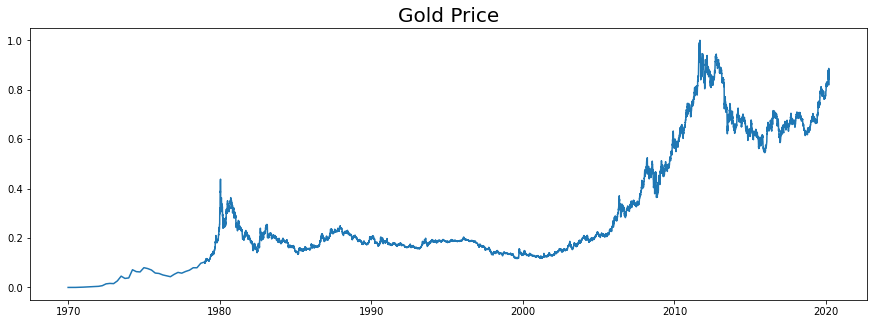

In [33]:
dates = df['Date'].values
values = df['Value'].values

plt.figure(figsize=(15,5))
plt.plot(dates, values)
plt.title('Gold Price', fontsize=20)

# Split Data

Dataset akan displit menjadi data training dan data validation dengan rasio 80% untuk data training dan 20% untuk data validation. Pada data time series, split data tidak dapat dilakukan secara random.

In [34]:
from sklearn.model_selection import train_test_split

value_train, value_test, date_train, date_test = train_test_split(values, dates, test_size = 0.2, shuffle=False)

In [35]:
date_train

array(['1970-01-01T00:00:00.000000000', '1970-04-01T00:00:00.000000000',
       '1970-07-01T00:00:00.000000000', ...,
       '2011-12-02T00:00:00.000000000', '2011-12-05T00:00:00.000000000',
       '2011-12-06T00:00:00.000000000'], dtype='datetime64[ns]')

In [36]:
date_test

array(['2011-12-07T00:00:00.000000000', '2011-12-08T00:00:00.000000000',
       '2011-12-09T00:00:00.000000000', ...,
       '2020-03-11T00:00:00.000000000', '2020-03-12T00:00:00.000000000',
       '2020-03-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [37]:
len(value_train)

8629

In [38]:
len(value_test)

2158

Fungsi di bawah ini digunakan untuk merubah format data yang kita miliki agar dapat diterima oleh model. Fungsi di bawah menerima sebuah series/atribut yang telah dikonversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.

In [39]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

Untuk arsitektur model, pada pemodelan ini akan digunakan 2 buah layer LSTM.

In [40]:
train_set = windowed_dataset(value_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(value_test, window_size=60, batch_size=100, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(60, return_sequences=True),
    tf.keras.layers.LSTM(60),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1),
])

Kemudian pada optimizer akan digunakan parameter learning rate dan momentum sebagai berikut. Adapun loss function yang digunakan pada pemodelan ini adalah function yang umum digunakan pada kasus time series yaitu Huber dan metrik yang digunakan untuk mengevaluasi model adalah MAE.

In [41]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(
    loss = tf.keras.losses.Huber(),
    optimizer = optimizer,
    metrics = ['mae']
)

Pada pemodelan ini digunakan fungsi callback untuk memberi tahu model agar berhenti melakukan pelatihan ketika MAE dan Val_MAE kurang dari 10%.

In [42]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('mae') < 0.1 and logs.get('val_mae') < 0.1):
      self.model.stop_training = True
    
callbacks = myCallback()

Terlihat di bawah ini model berhasil menghentikan pelatihan ketika MAE dan val_mae telah kurang dari 10% pada epoch ke 236 dari 300. Artinya kita telah menghemat waktu eksekusi 64 epoch.

In [43]:
history = model.fit(
    train_set,
    validation_data = test_set,
    epochs = 300,
    verbose = 2,
    callbacks = [callbacks])

Epoch 1/300
86/86 - 15s - loss: 0.0382 - mae: 0.2318 - val_loss: 0.2325 - val_mae: 0.6760
Epoch 2/300
86/86 - 10s - loss: 0.0295 - mae: 0.1912 - val_loss: 0.2063 - val_mae: 0.6360
Epoch 3/300
86/86 - 10s - loss: 0.0239 - mae: 0.1605 - val_loss: 0.1859 - val_mae: 0.6030
Epoch 4/300
86/86 - 10s - loss: 0.0200 - mae: 0.1351 - val_loss: 0.1698 - val_mae: 0.5758
Epoch 5/300
86/86 - 10s - loss: 0.0172 - mae: 0.1138 - val_loss: 0.1566 - val_mae: 0.5526
Epoch 6/300
86/86 - 10s - loss: 0.0152 - mae: 0.0983 - val_loss: 0.1459 - val_mae: 0.5329
Epoch 7/300
86/86 - 10s - loss: 0.0138 - mae: 0.0878 - val_loss: 0.1370 - val_mae: 0.5159
Epoch 8/300
86/86 - 10s - loss: 0.0128 - mae: 0.0812 - val_loss: 0.1296 - val_mae: 0.5016
Epoch 9/300
86/86 - 10s - loss: 0.0120 - mae: 0.0778 - val_loss: 0.1236 - val_mae: 0.4894
Epoch 10/300
86/86 - 10s - loss: 0.0114 - mae: 0.0767 - val_loss: 0.1184 - val_mae: 0.4788
Epoch 11/300
86/86 - 10s - loss: 0.0110 - mae: 0.0772 - val_loss: 0.1141 - val_mae: 0.4697
Epoch 12

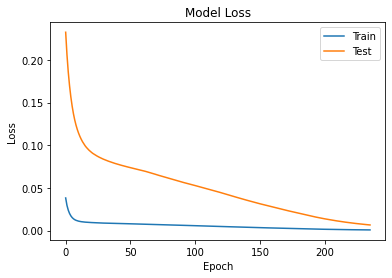

In [44]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

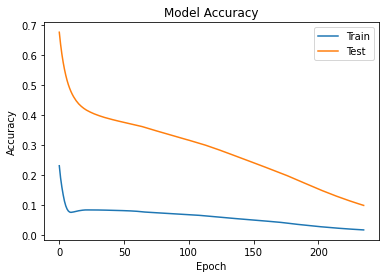

In [45]:
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()